#Hyperparameter Optimization
###Author: Andrew Mehrmann
###ASTR 596

* Hyperparameter: A model parameter that must be set outside of the actual model training
  * Traditional Parameters are learned from the data e.g. $\beta$ in linear regression
  * Hyperparameters are set manually, usually with the goal of controlling overfitting
 

Hyperparameter optimization refers to selecting values of hyperparameters such that they produce models that perform well on validation (test) data. Performance is assessed by some choice of one or many performance metrics.

* Performance Metric: A mathematical measure of how well a model performs, usually on validation (test) data. 
  * Examples: Accuracy, Precision, Recall, F1, ROC/AUC, MSE, Lift, etc.
  * Accuracy is *sometimes* a good metric, but often not as it assumes equal cost to both types of errors (FP, FN)
 
The choice of performance metric is extremely important to model assessment. Achieving 90% accuracy with a 90% target rate means you did about as good as the baseline assumption of positively classifying all observations.

This notebook will focus on two brute-force methods of hyperparameter optimization: Grid Search and Randomized search. Other methods include Bayesian optimization and gradient-based methods.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import Counter
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier

####Load in and Inspect the Data


In [3]:
dgts = datasets.load_digits()
print(dgts.DESCR)

 Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is 

In [4]:
#split the data into x and y

X = dgts.data
y = dgts.target

In [5]:
# examine the target
Counter(y)

Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})

In [6]:
#examine the predictors
X.shape

(1797, 64)

####Define the classifier

In [7]:
forest = RandomForestClassifier(n_estimators = 100, random_state=91)

In [8]:
#a function to turn grid search scores into a dataframe
def get_data_frame(scores):
    df = pd.DataFrame(scores)
    df.columns = ['params','mean_score','scores']
    df['sd'] = df.scores.apply(np.std)
    df = df.drop('scores',axis=1)
    df_sorted = df.sort('mean_score', ascending=False)
    return df_sorted.head(10)

##Grid (Exhaustive) Search

* 'Exhaustive search over specified parameter values for an estimator.' - [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV)
*  'grid search, or a parameter sweep...is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm' - [Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization) 

###### Define the parameter space to search

In [16]:
feat_range = np.arange(1,X.shape[1],10)
depth_range = np.arange(1,51,10)
boot_range = [True, False]

params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

n_combos = len(feat_range) + len(depth_range) + len(boot_range)

print('the exhaustive search will examine {0} candidates'.format(n_combos))

the exhaustive search will examine 14 candidates


######Perform Grid Search and inspect the results

In [17]:
grid = GridSearchCV(forest, params, cv = 5, n_jobs=-1, scoring='accuracy',random_state=91)

start = datetime.datetime.now()

grid_search = grid.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during exhaustive search'.format(elapsed.seconds))

df_grid = get_data_frame(grid.grid_scores_)
df_grid

120 seconds elapsed during exhaustive search


,params,mean_score,sd
63,"{u'max_features': 1, u'bootstrap': False, u'ma...",0.942682,0.017934
56,"{u'max_features': 1, u'bootstrap': False, u'ma...",0.942126,0.017389
64,"{u'max_features': 11, u'bootstrap': False, u'm...",0.941569,0.023188
57,"{u'max_features': 11, u'bootstrap': False, u'm...",0.941013,0.021541
43,"{u'max_features': 11, u'bootstrap': False, u'm...",0.941013,0.019317
50,"{u'max_features': 11, u'bootstrap': False, u'm...",0.939343,0.020284
44,"{u'max_features': 21, u'bootstrap': False, u'm...",0.938787,0.024075
29,"{u'max_features': 11, u'bootstrap': True, u'ma...",0.938230,0.019928
28,"{u'max_features': 1, u'bootstrap': True, u'max...",0.937674,0.025697
14,"{u'max_features': 1, u'bootstrap': True, u'max...",0.937674,0.024745


##Randomized Search

######Define the parameter space to search
* There is a new parameter *n_iter*
* The feature ranges are now defined as discrete distributions (this doesn't really matter here, but if the parameter space we were searching was continuous, sklearn advises that it's best to use continuous distributions).<sup>*</sup>

<sup>*</sup>" It is highly recommended to use continuous distributions for continuous parameters." - [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)

In [61]:
n_iter = 5

feat_range = sp_randint(1,X.shape[1])
depth_range = sp_randint(1,51)
boot_range = [True, False]


params = {'max_features':feat_range,
         'max_depth':depth_range,
         'bootstrap':boot_range}

print('the randomized search will examine {0} candidates'.format(n_iter))

the randomized search will examine 5 candidates


######Perform Randomized Search and inspect the results

In [19]:
rand = RandomizedSearchCV(forest, params, cv=5, n_jobs=-1, n_iter=n_iter, scoring='accuracy', random_state=91)

start = datetime.datetime.now()

random_search = rand.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_rand = get_data_frame(rand.grid_scores_)
df_rand

14 seconds elapsed during randomized search


,params,mean_score,sd
2,"{u'max_features': 22, u'bootstrap': False, u'm...",0.934335,0.022956
0,"{u'max_features': 34, u'bootstrap': False, u'm...",0.927101,0.022500
3,"{u'max_features': 55, u'bootstrap': True, u'ma...",0.914858,0.027399
1,"{u'max_features': 42, u'bootstrap': False, u'm...",0.911519,0.029785
4,"{u'max_features': 62, u'bootstrap': True, u'ma...",0.905398,0.020044


This comparison shows that the best result from the randomized search is not statistically different than the best result from the grid search. This has two important implications:
1. The randomized search is more adaptable to huge data sets where computation time becomes unfeasable
2. Holding all else constant (including computation time), a randomized search allows us to search a larger parameter space.

######Perform repeated sampling to demonstrate

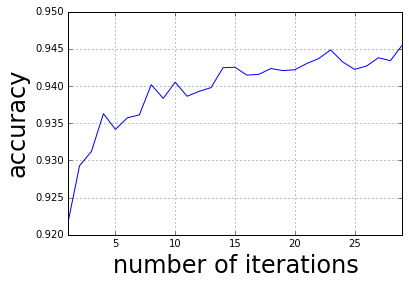

In [63]:
nrange = range(0,10)
iterange = range(1,30)
df_log = pd.DataFrame(index=iterange, columns=nrange)

for n in nrange:
    for n_iter in iterange:
        rand = RandomizedSearchCV(forest, params, cv=5, n_jobs=-1, n_iter=n_iter, 
                                  scoring='accuracy', random_state=91)
        random_search = rand.fit(X,y)
        df_rand = get_data_frame(rand.grid_scores_)
        df_log.loc[n_iter][n] = df_rand.iloc[0].mean_score

plt.xlabel('number of iterations',size=24)
plt.ylabel('accuracy',size=24)
df_log.mean(axis=1).plot() # plotting right from pandas series

##Pipelines

Pipelines allow you to chain functions together. This is useful when we want to optimize parameters on two or more functions. In this example, we first perfrom PCA on the data, then we perform our classification.  

*Note that this is a bad example statistically because PCA should not change our predictions much (it is simply a linear combination of the original variables). A real-world example would be text classification in which you would have to tune a text vectorizer and a classifier.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats import uniform

######Define pipeline and parameter space
* Note the new parameter **pc_range**
* Now that we have two function in a pipeline, we must specify which parameter belongs to which function

In [43]:
pca = PCA()

# we have to specify names for the elements of the pipeline
# I've called pca 'components' and the random forest 'rfc'
pipeline = Pipeline([("components", pca), ("rfc", forest)])

feat_range = uniform(0,1)
depth_range = sp_randint(1,51)
boot_range = [True, False]
pc_range = sp_randint(1,X.shape[1])

params = {'rfc__max_features':feat_range,
         'rfc__max_depth':depth_range,
         'rfc__bootstrap':boot_range,
         'components__n_components':pc_range}


######Perform Randomized Search and inspect the results

Notice that we simply pass the pipeline to the Randomized Search. 

In [44]:
search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, n_iter=20, scoring='accuracy', random_state=91)

start = datetime.datetime.now()

pipe_search = search.fit(X,y)

elapsed = datetime.datetime.now() - start
print('{0} seconds elapsed during randomized search'.format(elapsed.seconds))

df_pipe = get_data_frame(search.grid_scores_)
df_pipe

96 seconds elapsed during randomized search


,params,mean_score,sd
6,"{u'rfc__max_depth': 34, u'rfc__bootstrap': Fal...",0.929327,0.020363
16,"{u'rfc__max_depth': 44, u'rfc__bootstrap': Fal...",0.927657,0.025274
19,"{u'rfc__max_depth': 29, u'rfc__bootstrap': Tru...",0.922092,0.022473
14,"{u'rfc__max_depth': 25, u'rfc__bootstrap': Tru...",0.918197,0.017639
10,"{u'rfc__max_depth': 26, u'rfc__bootstrap': Tru...",0.914302,0.021233
8,"{u'rfc__max_depth': 14, u'rfc__bootstrap': Tru...",0.910406,0.018578
9,"{u'rfc__max_depth': 28, u'rfc__bootstrap': Fal...",0.909293,0.024291
15,"{u'rfc__max_depth': 39, u'rfc__bootstrap': Tru...",0.909293,0.025663
0,"{u'rfc__max_depth': 9, u'rfc__bootstrap': True...",0.903172,0.015028
3,"{u'rfc__max_depth': 17, u'rfc__bootstrap': Tru...",0.902615,0.016892


##Model Assessment

In practice, it is (sorta) acceptable to perform hyperparameter optimization on the entire dataset because the cross-validation scores are computed by fitting the model on a subset of the data and testing it on different data. After we have found the optimal values of hyperparameters, we can use them to train a model on training data to assess performance.

This step isn't totally necessary as we already have an estimate of our validation error, however we can access some extra functionality in scikit learn by doing it this way.

####Select and fit a model on training data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91)

In [46]:
forest = random_search.best_estimator_ # just grab the best estimator from before (the random search)
y_pred = forest.fit(X_train, y_train).predict(X_test)

####Confusion Matrices and Classification Reports

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [48]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

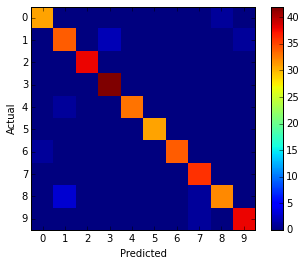

In [55]:
plt.imshow(df_confusion,interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)

In [56]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        32
          1       0.89      0.92      0.91        37
          2       1.00      1.00      1.00        38
          3       0.95      1.00      0.98        42
          4       1.00      0.97      0.99        34
          5       1.00      1.00      1.00        31
          6       1.00      0.97      0.99        35
          7       0.95      1.00      0.97        36
          8       0.97      0.89      0.93        36
          9       0.97      0.97      0.97        39

avg / total       0.97      0.97      0.97       360



###References

* http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf
* http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html